In [1]:
from dataset import get_datasets

train_dataset, test_dataset = get_datasets()

In [2]:
import pandas as pd
import torch.nn as nn
from torchvision import models
from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)
alexnet = models.alexnet(pretrained=True)
last_layer_classifier = nn.Sequential(
    nn.Linear(9216, len(df.columns) - 2), nn.Sigmoid()
)

c:\Users\USER\anaconda3\envs\playtorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\playtorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:20<00:00, 11.7MB/s] 


In [3]:
import wandb

PROJECT_NAME = "STAT4012Project"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yatshingl (cuhkstat4012proj). Use `wandb login --relogin` to force relogin


True

In [5]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from torch import optim
from model import pretrainedModel
import time

config = {
    "batch_size": 32,
    "loss_fn": nn.BCELoss,
    "lr": 0.000001,
    "optimizer": optim.Adam,
    "epochs": 5,
}

model_alexnet = pretrainedModel(
    alexnet,
    last_layer_classifier,
    len(df.columns) - 2,
    config["loss_fn"],
    config["optimizer"],
    lr=config["lr"],
)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=6, pin_memory=True)
validation_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=6, pin_memory=True)

run_name = "alexnet_" + str(int(time.time()))
logger = WandbLogger(name=run_name, project=PROJECT_NAME, log_model="all")
trainer = L.Trainer(max_epochs=config["epochs"], logger=logger)

trainer.fit(model_alexnet, train_loader, validation_loader)

c:\Users\USER\anaconda3\envs\playtorch\Lib\site-packages\lightning\pytorch\loggers\wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | features         | Sequential      | 2.5 M 
1 | class_classifier | Sequential      | 175 K 
2 | loss_fn          | BCELoss         | 0     
3 | metrics          | MultilabelAUROC | 0     
-----------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.579    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

c:\Users\USER\anaconda3\envs\playtorch\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 4: 100%|██████████| 13721/13721 [19:42<00:00, 11.60it/s, v_num=mdn8, train_auroc=0.550, train_loss_step=0.218, val_auroc_step=0.275, val_loss_step=0.190, val_auroc_epoch=0.571, val_loss_epoch=0.221, train_loss_epoch=0.220]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 13721/13721 [19:43<00:00, 11.59it/s, v_num=mdn8, train_auroc=0.550, train_loss_step=0.218, val_auroc_step=0.275, val_loss_step=0.190, val_auroc_epoch=0.571, val_loss_epoch=0.221, train_loss_epoch=0.220]


## Model Evaluation

In [8]:
import os
from model import pretrainedModel
import pandas as pd
from torchvision import models
import torch.nn as nn
from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)
alexnet = models.alexnet()
last_layer_classifier = nn.Sequential(
    nn.Linear(9216, len(df.columns) - 2), 
    nn.Sigmoid()
)

alexnet_1713092589_trained = pretrainedModel.load_from_checkpoint(
    os.path.join("AlexNet", "Alexnet_1713092589_ep5.ckpt"),
    pre_trained_model=alexnet,
    last_layer_classifier=last_layer_classifier,
    num_labels=len(df.columns) - 2,
)

In [12]:
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from dataset import PosterDataset

all_data = PosterDataset()
all_dataloader = DataLoader(all_data, batch_size=32, shuffle=False, num_workers=6, pin_memory=True)

trainer = L.Trainer(accelerator="gpu",devices=1)
predictions = trainer.predict(alexnet_1713092589_trained, all_dataloader)
all_prediction = np.concatenate(predictions)
prediction_filename = "alexnet_predictions.npz"
np.savez_compressed(prediction_filename, all_prediction)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\USER\anaconda3\envs\playtorch\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 17152/17152 [10:38<00:00, 26.88it/s]


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

all_prediction = np.load("alexnet_predictions.npz")["arr_0"]
train_indices, test_indices = train_test_split(
    np.arange(len(all_prediction)), test_size=0.2, random_state=42
)


def evaluate_auroc(y_true, y_pred):
    # Calculate ROC AUC for each label
    roc_auc_scores = {}
    for i in range(y_true.shape[1]):  # Iterate over each label
        roc_auc_scores[df.columns[i + 1][1:]] = roc_auc_score(
            y_true[:, i], y_pred[:, i]
        )

    # Print ROC AUC scores for each label
    results = pd.DataFrame(roc_auc_scores.items(), columns=["Genre", "ROC AUC"])
    print(results)
    # Calculate the average ROC AUC score across all labels
    average_roc_auc = np.mean(list(roc_auc_scores.values()))
    print(f"Average ROC AUC: {average_roc_auc:.4f}")

    # Plot the ROC curve
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=df.columns[i + 1][1:])
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multilabel ROC curve")
    plt.legend()
    plt.show()

              Genre   ROC AUC
0            Action  0.780684
1         Adventure  0.734035
2         Animation  0.880469
3            Comedy  0.732004
4             Crime  0.703571
5       Documentary  0.763756
6             Drama  0.674467
7            Family  0.762552
8           Fantasy  0.673291
9           History  0.658313
10           Horror  0.817163
11            Music  0.686454
12          Mystery  0.677616
13          Romance  0.735977
14  Science Fiction  0.735589
15         TV Movie  0.714423
16         Thriller  0.752478
17              War  0.722358
18          Western  0.846179
Average ROC AUC: 0.7395


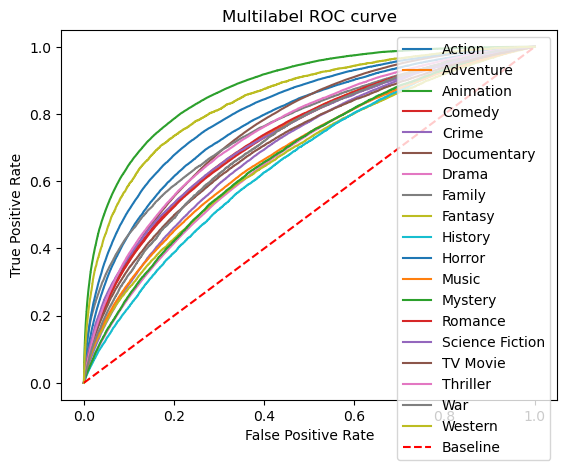

In [14]:
train_true = df.iloc[train_indices, 1:-1].to_numpy().astype(np.float32)
train_predictions = all_prediction[train_indices]

evaluate_auroc(train_true, train_predictions)

              Genre   ROC AUC
0            Action  0.772572
1         Adventure  0.721325
2         Animation  0.878548
3            Comedy  0.726023
4             Crime  0.691335
5       Documentary  0.759164
6             Drama  0.665667
7            Family  0.756397
8           Fantasy  0.664022
9           History  0.652122
10           Horror  0.816122
11            Music  0.675939
12          Mystery  0.660012
13          Romance  0.726221
14  Science Fiction  0.724640
15         TV Movie  0.699697
16         Thriller  0.748875
17              War  0.709438
18          Western  0.838027
Average ROC AUC: 0.7308


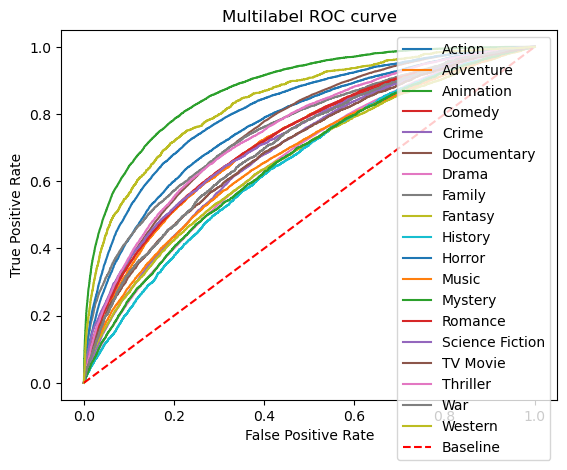

In [15]:
test_true = df.iloc[test_indices, 1:-1].to_numpy().astype(np.float32)
test_predictions = all_prediction[test_indices]
evaluate_auroc(test_true, test_predictions)

In [16]:
import pickle

# Save the model to a pickle file
with open("alexnet.pkl", "wb") as f:
    pickle.dump(alexnet_1713092589_trained, f)

In [17]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from PIL import Image
import torch

from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)


def predict_image(*args, plot=False):
    img = np.asarray(Image.open(*args))[:, :, :3]
    if plot:
        plt.imshow(img)
        plt.show()
    img = PosterDataset.get_default_transform()(img)
    alexnet_1713092589_trained.eval()
    with torch.no_grad():
        predictions = alexnet_1713092589_trained(img.unsqueeze(0)).flatten().numpy()
    rounded_predictions = np.round(predictions, 2)
    df_predictions = pd.DataFrame(
        list(zip([genre[1:] for genre in df.columns[1:-1]], rounded_predictions)),
        columns=["Genre", "Probability"],
    )
    return df_predictions

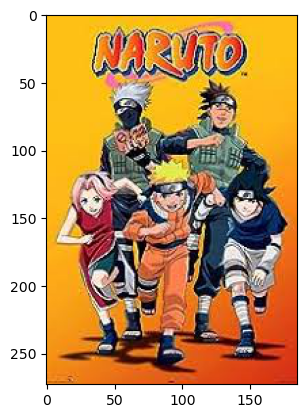

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Probability,0.23,0.12,0.39,0.63,0.04,0.04,0.1,0.1,0.08,0.01,0.01,0.07,0.01,0.04,0.04,0.0,0.01,0.02,0.1


In [18]:
predict_image("img/naruto.jpeg", plot=True).T